# 修正まとめ

In [1]:
from pathlib import Path
import shutil
import subprocess
import numpy as np
from PyFoam.RunDictionary.ParsedParameterFile import ParsedParameterFile
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from pathlib import Path
import numpy as np

# 本章で使用するライブラリ
import shutil
import subprocess
import matplotlib.pyplot as plt
from PyFoam.RunDictionary.ParsedParameterFile import ParsedParameterFile
import pandas as pd
import os


def clone_file(orgCase, resultDir):
    "orgCaseをresultDirに重複しないようにコピー"
    baseName = Path(orgCase).name

    addName = None
    if addName!=None:
        baseName += f'_{addName}'

    Path(resultDir).mkdir(exist_ok=True, parents=True)

    n=0
    newCase = Path(resultDir) / f'{baseName}_{n}'

    while newCase.is_dir():
        n += 1
        newCase = Path(resultDir) / f'{baseName}_{n}'

    shutil.copytree(orgCase, newCase)
    
    return newCase
    
def cd_result(resultDir, newCase):
    #抗力係数の出力
    keys = ['forceCoeffs']
    startTime = 0
    datfile = 'forceCoeffs.dat'
    
    key = keys[0]
    df = pd.DataFrame()

    case = str(newCase)
    name = os.path.basename(case)
    forceFile = f'{resultDir}/{case}/postProcessing/{key}/{startTime}/{datfile}'
    df_cd = pd.read_csv(forceFile, sep='\t', header=8,index_col=0)
    cd = np.array([ valStr for keys, valStr in df_cd[df_cd.columns[1]].items() ])
 
    return cd

def new_parameter(newU, newCase):
    # 流速の変更
    fileU = ParsedParameterFile(newCase / '0/U')
    fileU.content['boundaryField']['XMin']['value'] = 'uniform ({:.6f} 0 0)'.format(newU)
    fileU.content['internalField'] = 'uniform ({:.6f} 0 0)'.format(newU)
    fileU.writeFile()
    print(f'Inlet(Xmin) U is now {newU}')
    print(f'Inlet(initial) U is now {newU}')
    
    # 抗力係数の代表速度の変更
    file_controlDict = ParsedParameterFile(newCase / 'system/controlDict')
    file_controlDict.content['functions']['forceCoeffs']['magUInf'] = newU
    file_controlDict.writeFile()

def cd_Re(newU, cd):
    U = newU
    L = 250E-3
    mu = 1.511e-05
    Re = U*L/mu
    # print(f"cd={cd[-1]}")
    # print(f"レイノルズ数={round(Re,1)}")
    
    return Re

def Allrun(newCase):
    "Allrunを実行"
    out_run = subprocess.check_output(['./Allrun'], cwd=newCase)
    return out_run.decode()

def Cd_Re():
    Re_ana = np.linspace(0.01, 10000000, 1000000)
    cd_ana = 24/Re_ana + ( 2.6*(Re_ana/5) )/(1+(Re_ana)**1.52) +  ( 0.411*(Re_ana/263000)**(-7.94) )/(1+(Re_ana/263000)**(-8.00)) +(Re_ana**0.80)/461000
        
    return Re_ana, cd_ana

In [2]:
orgCase = 'orgCase/base_k-epsilon'
resultDir = 'resultDir/'

newU_list = [0.000001,0.00001,0.00002,0.00003, 0.001, 0.01, 0.1, 1.0, 10.0, 20.0, 30.0,40.0,100.0]

In [3]:
# 計算実行

for newU in newU_list:
    newCase = clone_file(orgCase, resultDir)
    new_parameter(newU, newCase)
    Allrun(newCase)

    print('='*50)

Inlet(Xmin) U is now 1e-06
Inlet(initial) U is now 1e-06
Inlet(Xmin) U is now 1e-05
Inlet(initial) U is now 1e-05
Inlet(Xmin) U is now 2e-05
Inlet(initial) U is now 2e-05
Inlet(Xmin) U is now 3e-05
Inlet(initial) U is now 3e-05
Inlet(Xmin) U is now 0.001
Inlet(initial) U is now 0.001
Inlet(Xmin) U is now 0.01
Inlet(initial) U is now 0.01
Inlet(Xmin) U is now 0.1
Inlet(initial) U is now 0.1
Inlet(Xmin) U is now 1.0
Inlet(initial) U is now 1.0
Inlet(Xmin) U is now 10.0
Inlet(initial) U is now 10.0
Inlet(Xmin) U is now 20.0
Inlet(initial) U is now 20.0
Inlet(Xmin) U is now 30.0
Inlet(initial) U is now 30.0
Inlet(Xmin) U is now 40.0
Inlet(initial) U is now 40.0
Inlet(Xmin) U is now 100.0
Inlet(initial) U is now 100.0


In [31]:
from natsort import natsorted

newCase_list = natsorted (os.listdir(resultDir) ) 

newCase_list

['base_k-epsilon_0',
 'base_k-epsilon_1',
 'base_k-epsilon_2',
 'base_k-epsilon_3',
 'base_k-epsilon_4',
 'base_k-epsilon_5',
 'base_k-epsilon_6',
 'base_k-epsilon_7',
 'base_k-epsilon_8',
 'base_k-epsilon_9',
 'base_k-epsilon_10',
 'base_k-epsilon_11',
 'base_k-epsilon_12']

In [32]:
cd_list = []
Re_list = []

for i, newCase in enumerate(newCase_list):
    cd = cd_result(resultDir, newCase)
    Re = cd_Re(newU_list[i], cd)
    
    
    cd_list.append(cd[-1])
    Re_list.append(Re)

In [33]:
Re_ana, cd_ana = Cd_Re()

df_cdRe = pd.DataFrame()
df_cdRe['Re'] = Re_list
df_cdRe['cd'] = cd_list

df_cdRe

,Re,cd
0,1.654533e-02,2613.540000
1,1.654533e-01,261.387400
2,3.309067e-01,130.722300
3,4.963600e-01,87.083340
4,1.654533e+01,3.632683
5,1.654533e+02,1.039471
6,1.654533e+03,0.567880
7,1.654533e+04,0.396669
8,1.654533e+05,0.407806
9,3.309067e+05,0.403391


Text(0, 0.5, 'log10(Cd)')

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


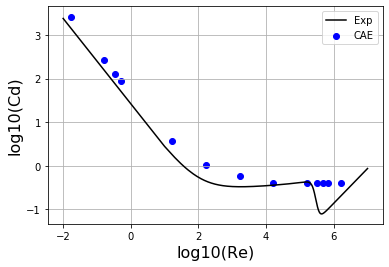

In [34]:
plt.scatter(np.log10(df_cdRe['Re']), np.log10(df_cdRe['cd']), color='blue', label = 'CAE')
plt.plot(np.log10(Re_ana), np.log10(cd_ana), color='black', label='Exp')
plt.grid()
plt.legend()
plt.xlabel('log10(Re)',fontsize=16)
plt.ylabel('log10(Cd)',fontsize=16)